In [1]:
import pytraj as pt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



In [2]:
# Plotting parameters
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.grid'] = False
# Legend Parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['legend.fontsize'] = 16

In [3]:
# Load psf and dcd
psf_name = "./bromoform_186_nve_2000Frames.psf"
traj_path = "./bromoform_186_nve_2000Frames.dcd"
traj_object = pt.load(traj_path, psf_name)

In [4]:
# Define carbon and hydrogen mask for dipole calculation
central_carbon_mask = '@CBR'
hydrogen_mask = '@HCB'

In [5]:
# Calculate orientational autocorrelation with sliding window

# Parameters
n_bromoforms = 186
trajectory_length = 2000  # Total trajectory length in frames
ps_window = 50  # Sliding window size of 50 ps (50 frames)
step_size = 1   
n_windows = (trajectory_length - ps_window) // step_size + 1

# Placeholder array to accumulate the autocorrelation functions for all windows and CHBR3
all_autocorrs = np.zeros((n_windows, ps_window))

# Loop through each bromoform in the trajectory to obtain ensemble avg
for resid in range(n_bromoforms):
    
    # Select the nth bromoform from the trajectory object
    bromoform_traj = traj_object[':{}'.format(resid + 1)]

    # Calculate dipole vectors 
    dipole_vector_timeseries = pt.vector.vector(
        traj=bromoform_traj, 
        command="{} {}".format(central_carbon_mask, hydrogen_mask)
    )  # Shape: (trajectory_length, 3)

    # Normalize dipole vectors to get unit vectors
    dipole_unit_vectors = dipole_vector_timeseries / np.linalg.norm(
        dipole_vector_timeseries, axis=1)[:, np.newaxis]

    # Loop over each sliding window
    for i in range(n_windows):
        start_frame = i * step_size
        end_frame = start_frame + ps_window

        # Select the dipole vector at the start of the current window
        dipole_vector_at_start = dipole_unit_vectors[start_frame]

        # Compute the autocorrelation function for the entire window 
        autocorr_nth_bromoform = np.zeros(ps_window)
        for t in range(ps_window):
            autocorr_nth_bromoform[t] = np.dot(dipole_vector_at_start, dipole_unit_vectors[start_frame + t])

        # Sum over all windows and molecules (ensemble averaging)
        all_autocorrs[i, :] += autocorr_nth_bromoform

# Average the autocorrelation functions over all windows and molecules
average_autocorr_per_window = np.mean(all_autocorrs, axis=0)
average_autocorr = average_autocorr_per_window / n_bromoforms

Fitted amplitude (A): 0.9811151281210687 ± 0.0045092307653681685
Fitted decay time (tau): 3.9931890676072865 ps ± 0.029267549509402704 ps


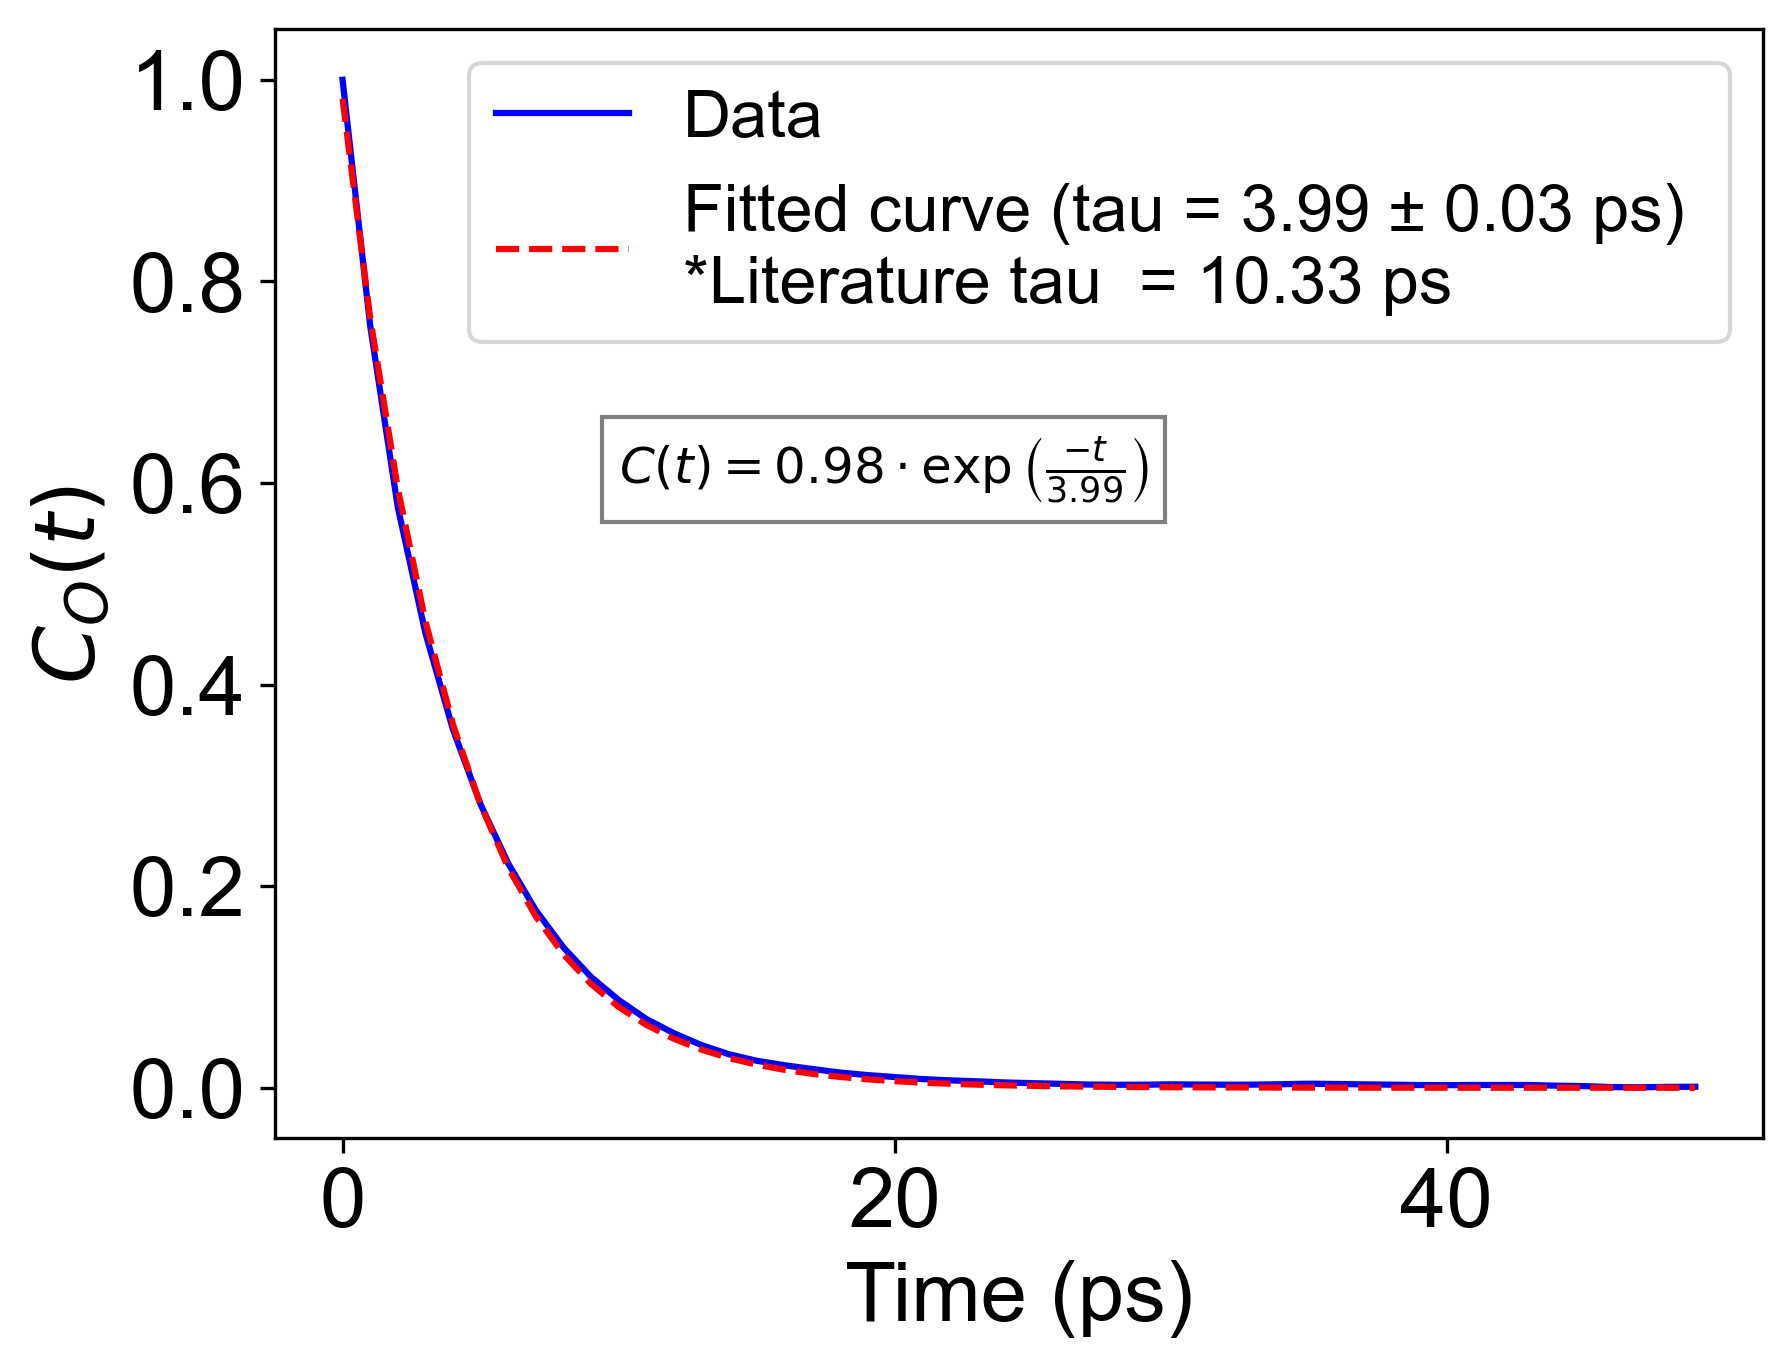

In [6]:

# Define the exponential decay function
def exponential_decay(t, A, tau):
    return A * np.exp((-t / tau))

time = np.arange(50)  # First 50 ps
autocorr_data = average_autocorr 

# Initial guess for the fit parameters: A=1 (initial value), tau=10 (initial guess for decay constant)
initial_guess = [1.0, 10.0]

# Perform the curve fitting
popt, pcov = curve_fit(exponential_decay, time, autocorr_data, p0=initial_guess)

# Extract the fitted parameters
A_fitted, tau_fitted = popt

# Extract the standard errors of params (sqrt of the diagonal of the covariance matrix)
perr = np.sqrt(np.diag(pcov))
A_error, tau_error = perr

print(f"Fitted amplitude (A): {A_fitted} ± {A_error}")
print(f"Fitted decay time (tau): {tau_fitted} ps ± {tau_error} ps")

# Generate the fitted curve
fitted_curve = exponential_decay(time, A_fitted, tau_fitted)

# Plot the original data and the fitted curve together
plt.plot(time, autocorr_data, 'b-', label='Data')
plt.plot(time, fitted_curve, 'r--', label=f'Fitted curve (tau = {tau_fitted:.2f} ± {tau_error:.2f} ps) \n*Literature tau  = 10.33 ps')
plt.xlabel('Time (ps)')
plt.ylabel(r'$C_O(t)$')

# Write the best-fit equation to the plot
equation_text = r'$C(t) = {:.2f} \cdot \exp\left(\frac{{-t}}{{{:.2f}}}\right)$'.format(A_fitted, tau_fitted)
plt.text(10, 0.6, equation_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.show()
